# Saline water body
## Import Python packages

In [1]:
from IceSystem import IceSystem
import matplotlib.pyplot as plt
import numpy as np
import utility_funcs

## Define shell structure
Starting with a pure ice shell, 10 km thick ($L_z$ or $D$) with a surface temperature of 110 K ($T_\text{surf}$). We will choose a 10 km wide horizontal domain ($L_x$), and assume the basal temperature is water at ~1 atm, 273.15 K ($T_\text{bot}$).

In [2]:
# set ice shell parameters
shell_thickness = 5e3  # m
shell_width = 10e3  # m
surface_temp = 110.  # K
basal_temp = 273.15  # K

Set some numerical parameters. This time, we'll choose smaller spatial step size ($\Delta z$ and $\Delta x$) for finer spatial resolution. To compensate, we'll exploit the symmetry of our system by calling the <code>use_X_symmetry</code> parameter in creation of our ice shell

In [3]:
# spatial step sizes
dz = dx = 10.  # m

# initialize model with chosen parameters
model = IceSystem(Lx=shell_width, Lz=shell_thickness, dx=dx, dz=dz, use_X_symmetry=1)

## Initial temperature profile
We will assume that ice has a temperature-dependent conductivity
$$ k_i = {567 \over T}$$
and initialize the temperature profile to a steady state
$$ T(z) = T_\text{surf}\left( {T_\text{bot} \over T_\text{surf}} \right) ^ {z/D} $$

In [4]:
model.init_T(Tsurf=surface_temp, Tbot=basal_temp)

init_T(Tsurf = 110.0, Tbot = 273.15)
	 Temperature profile initialized to non-linear


## Initialize a water body
Assuming we have a 250 m thick ($h$) elliptical sill thats emplaced 1 km below the surface ($d$) and is 4.8 km in diameter and the water is at melting temperature (273.15 K) ($T_\text{intrusion}$).

In [5]:
sill_thickness = 250.  # m
sill_depth = 1e3  # m
sill_radius = 2.4e3 # m
sill_temp = 273.15  # K

model.init_intrusion(T=sill_temp, depth=sill_depth, thickness=sill_thickness, radius=sill_radius)

We can plot the initital temperature distribution to show the initial sill geometry as well as how the symmetry is exploited

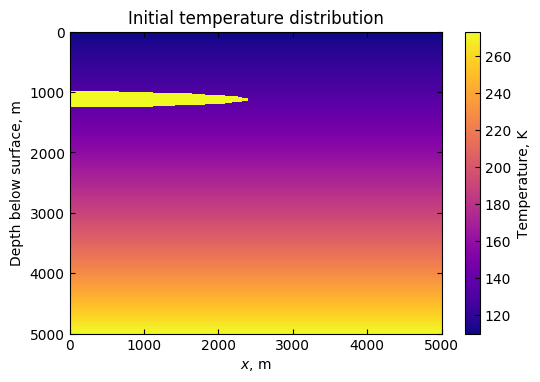

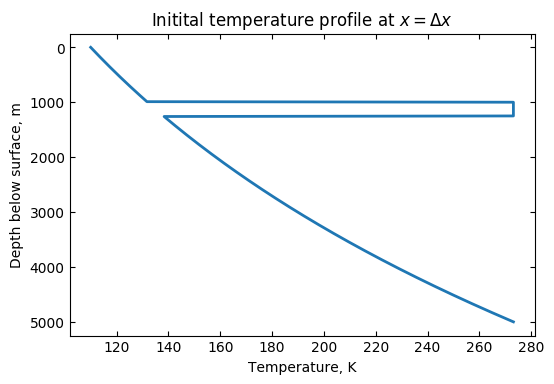

In [6]:
plt.figure(dpi=100)
plt.title("Initial temperature distribution")
plt.pcolormesh(model.X, model.Z, model.T, cmap="plasma")
plt.colorbar(label="Temperature, K")
plt.xlabel("$x$, m")
plt.ylabel("Depth below surface, m")
plt.gca().invert_yaxis()
plt.show()

plt.figure(dpi=100)
plt.title("Initital temperature profile at $x=\Delta x$")
# T[:, 1] = depth-temperature profile at x = dx
plt.plot(model.T[:,1], model.Z[:,1])
plt.xlabel("Temperature, K")
plt.ylabel("Depth below surface, m")
plt.gca().invert_yaxis()
plt.show()

## Initialize some salt
Say we want our water body to be ocean-sourced, then we must choose the composition of the salt and the concentration. We'll use 12.3 ppt (g salt/kg water) magnesium sulfate (MgSO$_4$). 

In [7]:
composition = 'MgSO4'
concentration = 12.3

Since our shell is also ocean-sourced, it will also have some distribution of salt in it (Buffo et al., in review), given by
$$ S_\text{total}(z) = a + {b \over c - z} $$
where $a,b,c$ are composition- and concentration-dependent constants and $S$ is the bulk salinity at depth $z$ below the surface.

This does mean that the basal temperature must be changed to match the melting temperature of water with 12.3 ppt MgSO$_4$, otherwise the whole base of the shell will melt! The melting temperature is given by a quadratic fit to FREZCHEM data ($T_m = aS^2 + bS+c$)

In [8]:
model.init_salinity(composition=composition, concentration=concentration, shell=True)

-- Adjusting temperature profile: Tsurf = 110.0, Tbot = 273.03835596041466
init_T(Tsurf = 110.0, Tbot = 273.03835596041466)
	 Temperature profile initialized to non-linear
--Updating intrusion temperature to reflect initial salinity, Tint = 272.854765171468


Now the temperature profile will be slightly different

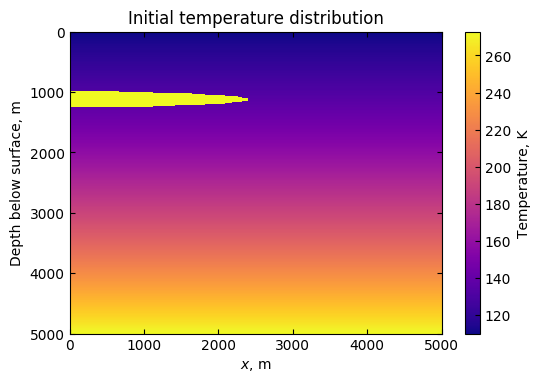

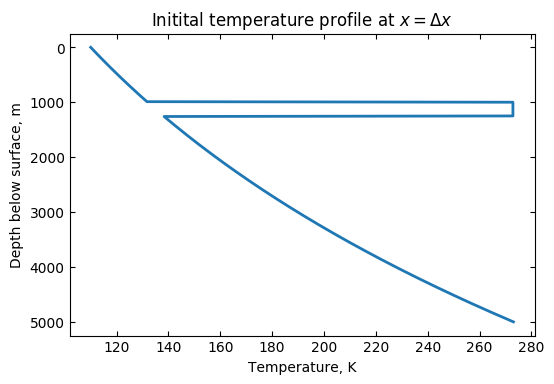

In [9]:
plt.figure(dpi=100)
plt.title("Initial temperature distribution")
plt.pcolormesh(model.X, model.Z, model.T, cmap="plasma")
plt.colorbar(label="Temperature, K")
plt.xlabel("$x$, m")
plt.ylabel("Depth below surface, m")
plt.gca().invert_yaxis()
plt.show()

plt.figure(dpi=100)
plt.title("Initital temperature profile at $x=\Delta x$")
# T[:, 1] = depth-temperature profile at x = dx
plt.plot(model.T[:,1], model.Z[:,1])
plt.xlabel("Temperature, K")
plt.ylabel("Depth below surface, m")
plt.gca().invert_yaxis()
plt.show()

We can also visualize the distribution of salts in the shell by using <code>S</code>

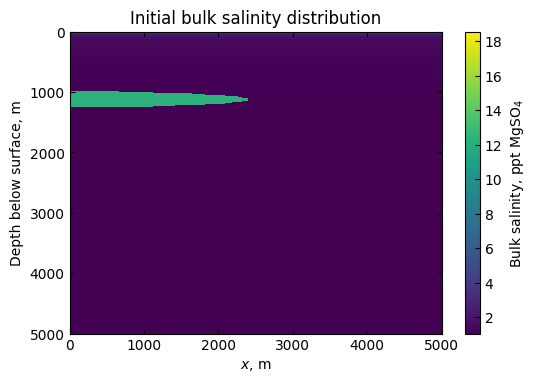

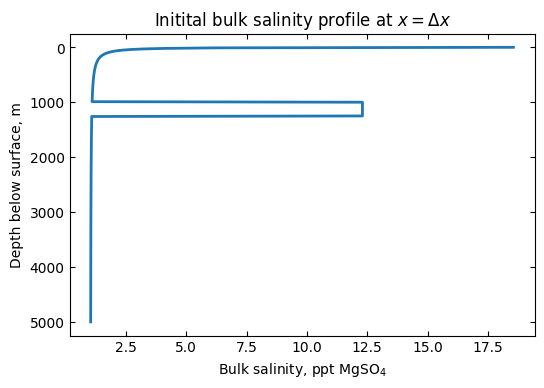

In [10]:
plt.figure(dpi=100)
plt.title("Initial bulk salinity distribution")
plt.pcolormesh(model.X, model.Z, model.S, cmap="viridis")
plt.colorbar(label="Bulk salinity, ppt MgSO$_4$")
plt.xlabel("$x$, m")
plt.ylabel("Depth below surface, m")
plt.gca().invert_yaxis()
plt.show()

plt.figure(dpi=100)
plt.title("Initital bulk salinity profile at $x=\Delta x$")
# T[:, 1] = depth-temperature profile at x = dx
plt.plot(model.S[:,1], model.Z[:,1])
plt.xlabel("Bulk salinity, ppt MgSO$_4$")
plt.ylabel("Depth below surface, m")
plt.gca().invert_yaxis()
plt.show()

## Run a simulation
Choosing our time step, boundary conditions, and final time to be the same as last time

In [11]:
dtmax =  min(model.dx, model.dz) ** 2 * model.rhoc.min() / (3 * model.k.max() ** 2)
dt = 0.1 * dtmax

# top=True and bottom=True allow constant boundary conditions and are default
model.set_boundaryconditions(top=True, bottom=True, sides='NoFlux')

final_time = 200 * model.constants.styr  # yrs * s/yr
number_of_time_steps = int(final_time/dt)

## Choosing outputs
This time, we might want to track various properties of our system through our simulation. We can do that by choosing which to track -- any of the various matrices created in the simulation, i.e. <code>T,phi,S</code> etc. -- or some others like the position of the freeze fronts. 

First, we choose the frequency at which to output the results. Let's choose an output every 2 years which will give us a 100 results over the final time chosen

In [12]:
output_frequency = int(2 * model.constants.styr / dt)

Then lets track the salinity <code>S</code>, temperature <code>T</code>, liquid fraction <code>phi</code>, and the percentage of water left <code>percent frozen</code> by creating a list of strings noting these

In [13]:
outputs = ['S', 'T', 'phi', 'percent frozen']

<i>Note: be careful with how many outputs and the output frequency. Although the dill package is fairly fast at saving files to disk and the file sizes are relatively small, too frequent can slow down simulations and create large files at the end (the results file by itself is ~600 MB alone in this example!).</i>

Finally, we want to choose a place to temporarily store the outputs so we don't have to store all matrices through time in memory as well as a unique name for the file to distinguish it

In [14]:
output_directory = "./"  # output to current directory
output_filenames = "salt"

model.outputs.choose(model, file_path=output_directory, file_name=output_filenames,
              output_list=outputs, output_frequency=output_frequency)

## Run a simulation
Just in case it freezes, we'll make sure to stop the simulation!

In [15]:
model.freezestop = 1
model.solve_heat(nt=number_of_time_steps, dt=dt)

Starting simulation with
-------------------------
	 total model time:  6307897007.359134s, 199.99673453897063yr
	   dt = 242938.45589675076 s
	 Ice shell thickness: 5000.0 m
	 Lateral domain size: 5000.0 m
	    dz = 10.0 m;  dx = 10.0 m
	 surface temperature: 110.0 K
	 bottom temperature:  273.03835596041466 K
	 boundary conditions:
	    top:     Dirichlet
	    bottom:  Dirichlet
	    sides:   NoFlux
	 sources/sinks:
	    tidal heating:  off
	    latent heat:    on
	 tolerances:
	    temperature:     0.1
	    liquid fraction: 0.01
	    salinity:        1
	 thermal properties:
	    ki(T):    on
	    ci(T):    off
	 intrusion/salt:
	    radius:    2400.0m
	    thickness: 250.0m
	    depth:     1000.0m
	    salinity: on
	       composition:    MgSO4
	       concentration:  12.3ppt
	 other:
	     stop on freeze: on
-------------------------
Requested outputs: ['S', 'T', 'phi', 'percent frozen', 'time']


Lets look really quickly at some of the final results

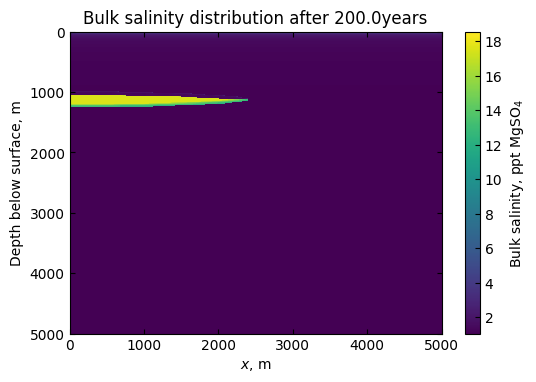

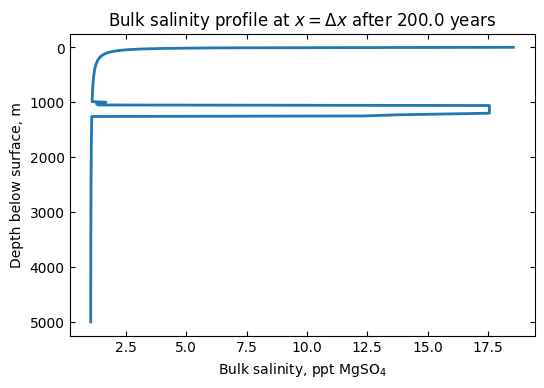

In [16]:
years_passed = model.model_time/model.constants.styr
plt.figure(dpi=100)
plt.title("Bulk salinity distribution after {:0.01f}years".format(years_passed))
plt.pcolormesh(model.X, model.Z, model.S, cmap="viridis")
plt.colorbar(label="Bulk salinity, ppt MgSO$_4$")
plt.xlabel("$x$, m")
plt.ylabel("Depth below surface, m")
plt.gca().invert_yaxis()
plt.show()

plt.figure(dpi=100)
plt.title("Bulk salinity profile at $x=\Delta x$ after {:0.01f} years".format(years_passed))
# T[:, 1] = depth-temperature profile at x = dx
plt.plot(model.S[:,1], model.Z[:,1])
plt.xlabel("Bulk salinity, ppt MgSO$_4$")
plt.ylabel("Depth below surface, m")
plt.gca().invert_yaxis()
plt.show()

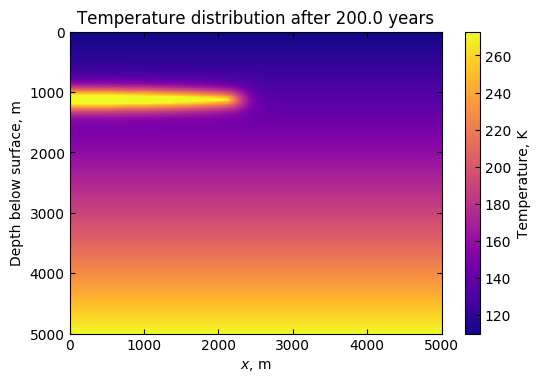

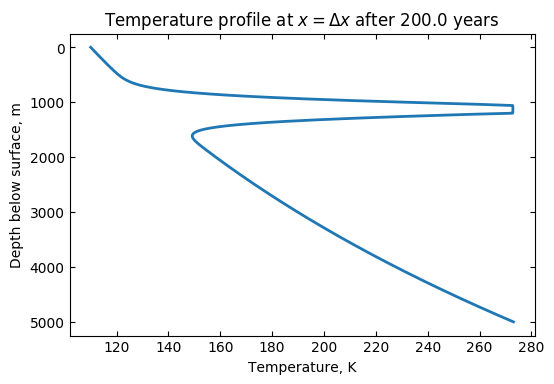

In [17]:
plt.figure(dpi=100)
plt.title("Temperature distribution after {:0.01f} years".format(years_passed))
plt.pcolormesh(model.X, model.Z, model.T, cmap="plasma")
plt.colorbar(label="Temperature, K")
plt.xlabel("$x$, m")
plt.ylabel("Depth below surface, m")
plt.gca().invert_yaxis()
plt.show()

plt.figure(dpi=100)
plt.title("Temperature profile at $x=\Delta x$ after {:0.01f} years".format(years_passed))
# T[:, 1] = depth-temperature profile at x = dx
plt.plot(model.T[:,1], model.Z[:,1])
plt.xlabel("Temperature, K")
plt.ylabel("Depth below surface, m")
plt.gca().invert_yaxis()
plt.show()

## Using the results
Now we can actually see how the system evolves by using our chosen outputs. 

First, lets gather all files into memory and in a single place. This will be a dictionary object with struture <code>var: output1, output2, ..., outputN</code> where each <code>var</code> is a requested output (i.e. temperature <code>'T'</code>) and each <code>output</code> is the output at each output interval (i.e. every 2 years here). The <code>time</card> key is always present.

In [18]:
results = model.outputs.get_all_data(model)
results.keys()

dict_keys(['S', 'T', 'phi', 'percent frozen', 'time'])

Saved variables that are normally in matrices are still that way and will therefore have a one time index and two spatial indices

In [19]:
for key in results: print(key, np.shape(results[key]))

S (101, 501, 501)
T (101, 501, 501)
phi (101, 501, 501)
percent frozen (101,)
time (101,)


We can plot the temperature field over time as an example

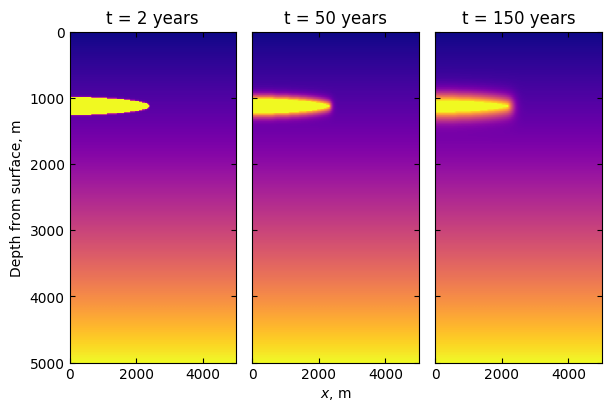

In [20]:
maxT, minT = model.T_initial.max(), model.T_initial.min()
fig, (ax1, ax2, ax3) = plt.subplots(num=1, nrows=1, ncols=3, constrained_layout=1,
                                   sharex='all', sharey='all', dpi=100)
ax1.set_title("t = 2 years")
ax1.pcolormesh(model.X, model.Z, results['T'][1], cmap="plasma", vmin=minT, vmax=maxT)
ax1.set_ylabel("Depth from surface, m")
ax1.invert_yaxis()

ax2.set_title("t = 50 years")
ax2.pcolormesh(model.X, model.Z, results['T'][25], cmap="plasma", vmin=minT, vmax=maxT)
ax2.set_xlabel("$x$, m")

ax3.set_title("t = 150 years")
ax3.pcolormesh(model.X, model.Z, results['T'][75], cmap="plasma", vmin=minT, vmax=maxT)

plt.show()

Or we can look at a cross-section through the middle through time of the salt

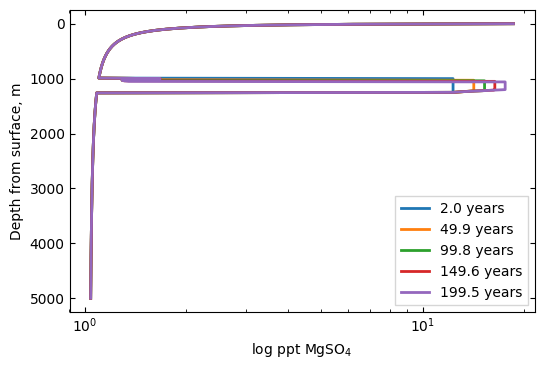

In [21]:
plt.figure(dpi=100)
x_idx = 1

yr_idxs = [1,25,50,75,100]
for i in yr_idxs:
    yr = results['time'][i]/model.constants.styr
    plt.plot(results['S'][i,:,x_idx], model.Z[:,x_idx], label="{:0.01f} years".format(yr))
plt.gca().invert_yaxis()
plt.xlabel("log ppt MgSO$_4$")
plt.ylabel("Depth from surface, m")
plt.xscale("log")
plt.legend()
plt.show()

Or we can track a particular grid cell for a particular variable in time

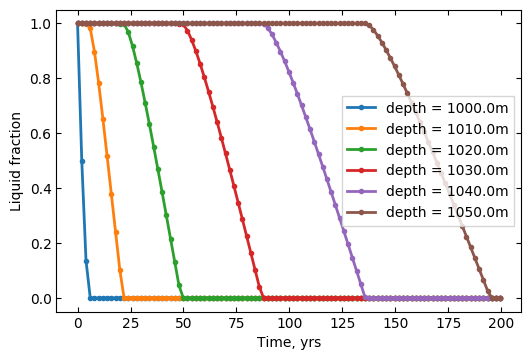

In [22]:
depths = [1e3, 1.01e3, 1.02e3, 1.03e3, 1.04e3, 1.05e3]
z_idx = [int(d/model.dz) for d in depths]
x_idx = 1

plt.figure(dpi=100)
for zi in z_idx:
    plt.plot(results['time']/model.constants.styr, 
             results['phi'][:, zi, x_idx], '.-',
             label='depth = {:.01f}m'.format(zi*model.dz))
plt.xlabel("Time, yrs")
plt.ylabel("Liquid fraction")
plt.legend()
plt.show()

Wow, look at those mushy layers!

The other 1d array we tracked was <code>'percent frozen'</code> which we can see by

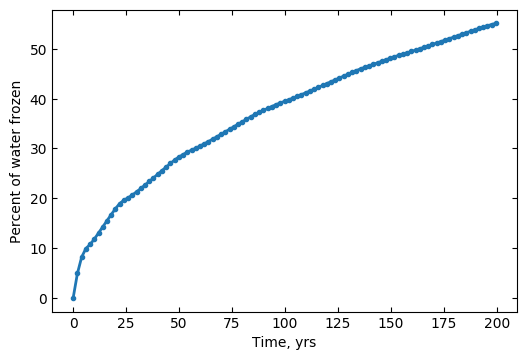

In [23]:
plt.figure(dpi=100)
plt.plot(results['time']/model.constants.styr, results['percent frozen']*100,'.-')
plt.xlabel("Time, yrs")
plt.ylabel("Percent of water frozen")
plt.show()

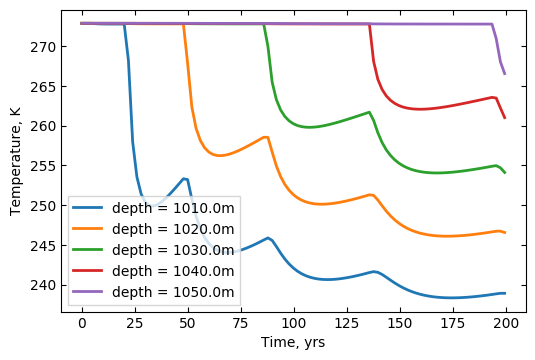

In [24]:
depths = [1.01e3, 1.02e3, 1.03e3, 1.04e3, 1.05e3]
z_idx = [int(d/model.dz) for d in depths]
x_idx = 1
plt.figure(dpi=100)
for zi in z_idx:
    plt.plot(results['time']/model.constants.styr, results['T'][:, zi, x_idx],
             label='depth = {:.01f}m'.format(zi*model.dz))
plt.xlabel("Time, yrs")
plt.ylabel("Temperature, K")
plt.legend()
plt.show()

Look at that latent heat!

## Saving/Loading the results
Now that we've had some fun with the data, we probably want to save it for later analysis. Its useful to save both the model that contains all the initial conditions as well as the results file separately,

In [25]:
# save the results to the output directory
results_file_name = "results"
utility_funcs.save_data(data=results, file_name=results_file_name, outputdir=output_directory)
# save the model to the output directory
model_file_name = "model"
utility_funcs.save_data(data=model, file_name=model_file_name, outputdir=output_directory)

naming file!


This saves each file as a ".pkl" file, a special file type that compresses the data for lower disk usage but comes with the caveat that it can't be really loaded by typical python means. So there's a specific load data function to help us out with that. 

<i>Note: The model file is saved with a pretty long name (variables are in the file name), so check your output directory!</i>

In [27]:
# be sure to include the entire path of the file in case it's stored somewhere else!
results_file = "./results.pkl"
RESULTS = utility_funcs.load_data(file_name=results_file)
# yeah... pretty long file name
model_file = "./model_cpT=off_issalt=on_Tsurf=110.000_Tbot=273.038_depth=1000.000_thickness=250.000_R_int=2400.000_composition=MgSO4_concentration=12.300_sidesBC=NoFlux.pkl"
MODEL = utility_funcs.load_data(file_name=model_file)

Now our newly loaded results file can be used in any way we like, just as before

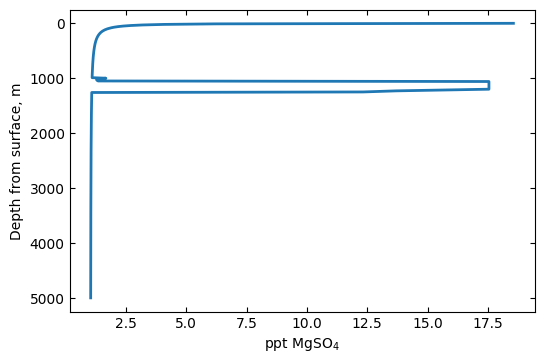

In [28]:
plt.figure(dpi=100)
plt.plot(RESULTS['S'][100,:,1], MODEL.Z[:,1])
plt.gca().invert_yaxis()
plt.xlabel("ppt MgSO$_4$")
plt.ylabel("Depth from surface, m")
plt.show()